In [1]:
import pickle
from functools import reduce

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC, LinearSVC

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.join("..", "scripts"))

In [3]:
from pathlib import Path
data_path = Path('../data')

In [4]:
from utils import *

In [5]:
# Load data

with open(data_path / "train_df.pkl", "rb") as f:
    train_df = pickle.load(f)

In [16]:
dev_df = pd.read_csv(data_path / 'train_dev.csv')
print((dev_df.id == train_df.id).all())
train_df['train_dev'] = dev_df['train_dev']

train_mask = train_df.train_dev == "train"
dev_mask = train_df.train_dev == "dev"
print(train_mask.mean(), dev_mask.mean())

True
0.7471479213664196 0.2528520786335804


In [18]:
train_df["combined_text"] = train_df.text.map(lambda lst: reduce(lambda a, b: a + b, lst))

In [107]:
from sklearn.pipeline import FeatureUnion, Pipeline

In [108]:
feature_union = FeatureUnion([('TfIdf_Unigram', TfidfVectorizer(min_df=5, max_df=0.6, ngram_range=(1, 1), strip_accents='unicode', norm='l2')),
                              ('TfIdf_Bigram',  TfidfVectorizer(min_df=5, max_df=0.6, ngram_range=(2, 2), strip_accents='unicode', norm='l2'))])

feature_pipeline = Pipeline([('feature_union', feature_union)])

In [109]:
print("extracting features")
feature_extractor = feature_pipeline.fit(train_df["combined_text"][train_mask].values)

# split into training and test set
X_train = feature_pipeline.transform(train_df["combined_text"][train_mask].values)
X_test = feature_pipeline.transform(train_df["combined_text"][dev_mask].values)
y_train = train_df["target"].values[train_mask]
y_test = train_df["target"].values[dev_mask]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

extracting features
(11592, 326781) (3923, 326781) (11592,) (3923,)


In [110]:
rr, bins = np.histogram(X_train.sum(0), bins=([0, 1, 2, 3] + list(range(4, 40, 3))))
tt, _ = np.histogram(X_test.sum(0), bins=bins)
print(rr/sum(rr))
print(tt/sum(tt))

[8.34561011e-01 9.09503511e-02 2.78358735e-02 1.38213377e-02
 1.64678463e-02 6.44300653e-03 3.24450305e-03 2.12824680e-03
 1.24812168e-03 8.77058481e-04 7.42126407e-04 6.10260971e-04
 4.04796222e-04 3.46530099e-04 3.18930357e-04]
[9.47681590e-01 2.89399500e-02 9.00183955e-03 4.33716649e-03
 5.14828090e-03 2.01707319e-03 9.91702147e-04 6.15222628e-04
 3.70357900e-04 3.33628191e-04 1.95891782e-04 1.37736409e-04
 1.04067509e-04 7.03986092e-05 5.50945637e-05]


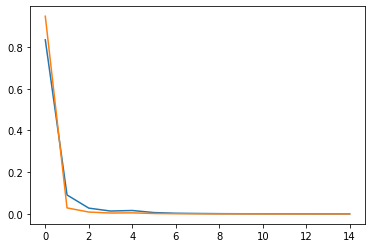

In [111]:
plt.plot(rr/rr.sum())
plt.plot(tt/tt.sum())

In [112]:
def train_eval(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(np_weighted_accuracy(y_test, y_pred), clf)

In [113]:
print("BASELINES-ZERO: ")
print("Always 0", np_weighted_accuracy(y_test, 0))
print("Always 1", np_weighted_accuracy(y_test, 1))
print("Always 2", np_weighted_accuracy(y_test, 2))

BASELINES-ZERO: 
Always 0 0.0673224043715847
Always 1 0.6476502732240437
Always 2 0.28502732240437156


In [ ]:
from sklearn.metrics import confusion_matrix

In [123]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer

base_classifier = LinearSVC()
distributions = dict(C=[0.01, 0.03, 0.1, 0.3, 1, 3])
clf = RandomizedSearchCV(base_classifier,
                         distributions,
                         random_state=0,
                         scoring=make_scorer(np_weighted_accuracy),
                         n_iter=5,
                         cv=3)
search = clf.fit(X_train, y_train)
print(search.best_params_)

{'C': 0.3}

In [129]:
clf.score(X_test, y_test)

0.7219672131147541